In [3]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print('>loaded %d examples for person: %s' % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)

# load train dataset
dir_loc = input("Enter the path of the directory with training data: ")
dir_loc.replace('\\', '/')
dir_loc += '/'
trainX, trainy = load_dataset(dir_loc)
print(trainX.shape, trainy.shape)
# load test dataset
dir_loc = input("Enter the path of the directory with testing data: ")
dir_loc.replace('\\', '/')
dir_loc += '/'
testX, testy = load_dataset(dir_loc)
# save arrays to one file in compressed format
savez_compressed('init_face_array.npz', trainX, trainy, testX, testy)


ModuleNotFoundError: No module named 'pyparsing'

In [19]:
%pip install tensorflow

In [23]:
%pip install keras_facenet

In [30]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
#from numpy import asarray
#from numpy import savez_compressed
from keras.models import load_model
from keras_facenet import FaceNet
import tensorflow as tf

# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels (global)
    #mean, std = face_pixels.mean(), face_pixels.std()
    #face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(samples)
    return yhat[0]

# load the face dataset
#data = load('init_face_array.npz')
#trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model


model = FaceNet();

print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('faces-embeddings.npz', newTrainX, trainy, newTestX, testy)



Loaded:  (217, 160, 160, 3) (217,) (49, 160, 160, 3) (49,)
Loaded Model
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step
(217, 512)
1/1 [==============================] - 0s 33ms/step
(49, 512)


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from random import choice
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load dataset
data = load('faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
testX_faces = data['arr_2']
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
#selection = 5
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])


#print the image with the predicted and expected output, please fork and help
''''print(random_face_pixels.shape)
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()'''


Dataset: train=217, test=49
Accuracy: train=100.000, test=100.000
Predicted: Prince_RAj_Kumar (20.360)
Expected: Prince_RAj_Kumar


"'print(random_face_pixels.shape)\npyplot.imshow(random_face_pixels)\ntitle = '%s (%.3f)' % (predict_names[0], class_probability)\npyplot.title(title)\npyplot.show()"

In [39]:
%pip install seaborn

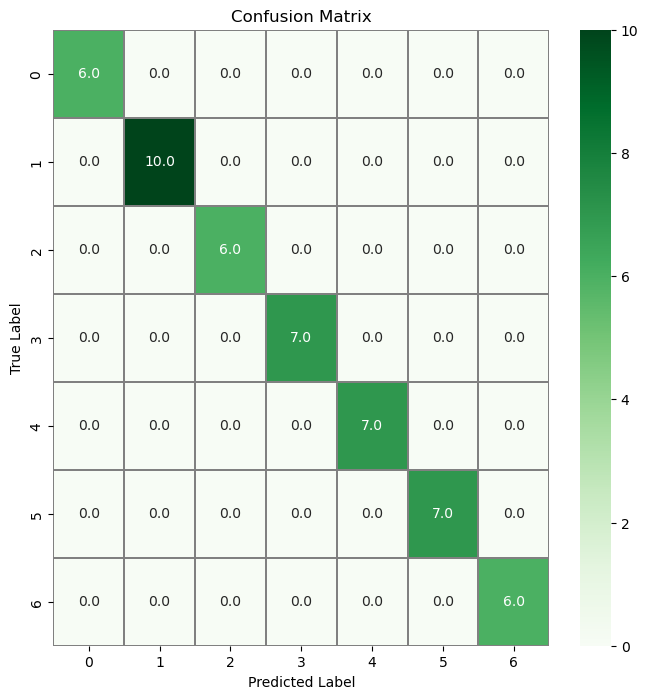

In [51]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predict the values from the validation dataset
Y_pred = model.predict(testX)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(testy) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(testy, Y_pred) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


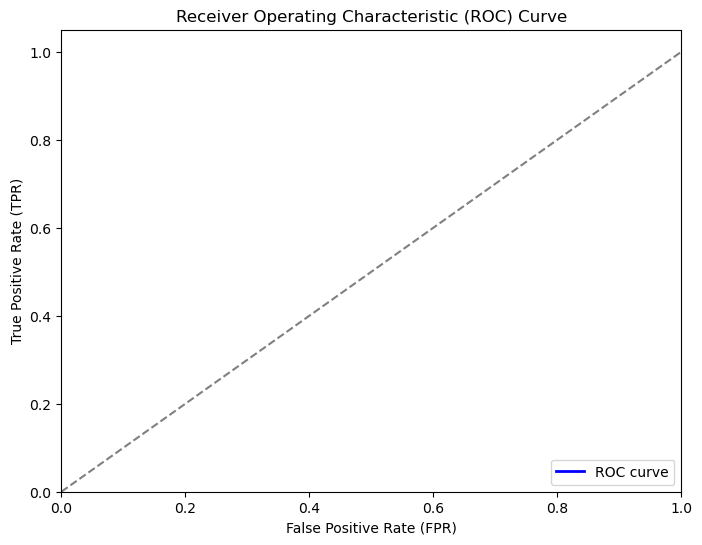

In [102]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a confusion matrix (confusion_mtx) for a binary classification problem
# Rows: Actual classes (0 for negative class, 1 for positive class)
# Columns: Predicted classes (0 for negative prediction, 1 for positive prediction)
# confusion_mtx = np.array([[TN, FP], [FN, TP]])

TN, FP = confusion_mtx[0, 0], confusion_mtx[0, 1]
FN, TP = confusion_mtx[1, 0], confusion_mtx[1, 1]

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
tpr = TP / (TP + FN)
fpr = FP / (FP + TN)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [105]:
%pip install opencv-python

In [115]:
import cv2
from mtcnn.mtcnn import MTCNN

detector = MTCNN()

t_im = cv2.imread(r"/Users/arunabhadutta/Desktop/Untitled Folder/face rec/test/Bidyajyoti_Bhuya/1000036141.jpg")
t_im = cv2.cvtColor(t_im, cv2.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 47ms/step


In [119]:
faces = detector.detect_faces(t_im)

if faces:
    x, y, w, h = faces[0]['box']
    
    # Verify that the cropping coordinates are within bounds
    if x >= 0 and y >= 0 and w > 0 and h > 0:
        # Crop the face region
        face_im = t_im[y:y+h, x:x+w]
        
        # Check if the face size is suitable for resizing
        if face_im.shape[0] >= 160 and face_im.shape[1] >= 160:
            # Resize the cropped face
            resized_face_im = cv2.resize(face_im, (160, 160))
            
            # Assuming you have a function get_embedding that extracts embeddings
            test_embedding = get_embedding(resized_face_im)
            
            # Reshape the embedding
            test_embedding = test_embedding.reshape(1, -1)
            
            # Assuming you have a model for prediction named 'model'
            Y_pred = model.predict(test_embedding)
            
            # Print the prediction result (this could be different depending on your model)
            print("Predicted class:", Y_pred)
        else:
            print("Detected face is too small for resizing.")
    else:
        print("Invalid cropping coordinates.")
else:
    print("No face detected.")

1/1 [==============================] - 0s 13ms/step
Detected face is too small for resizing.


In [120]:
test_embedding = test_embedding.reshape(1,-1)
Y_pred = model.predict(test_embedding)

NameError: name 'test_embedding' is not defined